In [1]:
# Generative Adversarial Network (GAN) 예시
# 기본 GAN (original GAN) 알고리즘을 이용하여 정규분포에서 샘플링한 데이터 (Real Data)와
# 유사한 Fake Data를 생성한다. Real Data와 Fake Data의 분포가 잘 일치하는지 확인한다.
#
# 원 논문 : Ian J. Goodfellow, et, al., 2014, Generative Adversarial Nets.
# 위 논문의 Psedudo code (Section 4. Algorithm 1)를 위주로 하였음.
# 참고 : Original GAN은 unstable, mode collapse 등의 문제가 있으며, 최근 변형된 알고리즘이
#       많이 개발되어 있다. 여기서는 원 알고리즘을 사용하였으므로 결과가 다소 unstable 할 수 있다.
#
# 2018.9.10, 아마추어퀀트 (조성현)
# -----------------------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 정규분포로부터 데이터를 샘플링한다
realData = np.random.normal(size=1000) #x (1차원 1개)
realData = realData.reshape(realData.shape[0], 1)

In [3]:
# 데이터 P, Q에 대한 KL divergence를 계산한다.
def KL(P, Q):
    # 두 데이터의 분포를 계산한다
    histP, binsP = np.histogram(P, bins=50)
    histQ, binsQ = np.histogram(Q, bins=binsP)
    
    # 두 분포를 pdf로 만들기 위해 normalization한다.
    histP = histP / (np.sum(histP) + 1e-8)
    histQ = histQ / (np.sum(histQ) + 1e-8)

    # KL divergence를 계산한다
    kld = np.sum(histP * np.log(histP / histQ))
    return histP, histQ, kld

In [4]:
# log 안에 0이 들어가는 것을 방지한다.
def myLog(x):
    return tf.log(x + 1e-8)

In [5]:
# Discriminator Network을 생성한다.
nDInput = realData.shape[1] #x (1차원 1개)
nDHidden = 8
nDOutput = 1 #판별용, 무조건 1개!

In [6]:
tf.reset_default_graph()
xavier = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, shape=[None, nDInput], name='x')
D_Wh = tf.Variable(xavier([nDInput, nDHidden]), name='D_Wh')#랜덤
D_Bh = tf.Variable(xavier(shape=[nDHidden]), name='D_Bh')#랜덤
D_Wo = tf.Variable(xavier([nDHidden, nDOutput]), name='D_Wo')#랜덤
D_Bo = tf.Variable(xavier(shape=[nDOutput]), name='D_Bo')#랜덤
thetaD = [D_Wh, D_Bh, D_Wo, D_Bo] # θD : 업데이트 대상


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Generator Network을 생성한다
nGInput = 8
nGHidden = 4
nGOutput = nDInput
#필수!!! D의 output 개수 = 1
#       G의 output 개수 = D의 input 개수
z = tf.placeholder(tf.float32, shape=[None, nGInput], name='z') #8개
G_Wh = tf.Variable(xavier([nGInput, nGHidden]), name='G_Wh')
G_Bh = tf.Variable(xavier(shape=[nGHidden]), name='G_Bh')
G_Wo = tf.Variable(xavier([nGHidden, nGOutput]), name='G_Wo')
G_Bo = tf.Variable(xavier(shape=[nGOutput]), name='G_Bo') #무조건 1개
thetaG = [G_Wh, G_Bh, G_Wo, G_Bo]

In [8]:
def Discriminator(x): # D(x)
    D_Ho = tf.nn.relu(tf.matmul(x, D_Wh) + D_Bh)
    D_Out = tf.matmul(D_Ho, D_Wo) + D_Bo
    return tf.nn.sigmoid(D_Out)

In [9]:
def Generator(z): # G(z)
    G_Ho = tf.nn.relu(tf.matmul(z, G_Wh) + G_Bh)
    G_Out = tf.matmul(G_Ho, G_Wo) + G_Bo
    return G_Out

In [10]:
def getNoise(m, n=nGInput): # Z
    z = np.random.uniform(-1., 1., size=[m, n]) #랜덤하게 아무렇게나 만들기!
    return z

In [11]:
# 각 Network의 출력값
Gz = Generator(z)
Dx = Discriminator(x)
DGz = Discriminator(Gz) #D(G(z))

In [12]:
# Loss function : 위 논문의 Section 3. 식 - (1)
# 이 함수를 쓰는 것보다 tensorflow에서 제공하는 tf.nn.sigmoid_cross_entropy_with_logits()을
# 사용하는 것이 더 좋다. 다음 예제부터 사용할 예정임.
D_loss = -tf.reduce_mean(myLog(Dx) + myLog(1 - DGz))
# G_loss = tf.reduce_mean(myLog(1 - DGz))
G_loss = -tf.reduce_mean(myLog(DGz)) # G_Loss는 이렇게 쓰는 것이 더 좋다
                                                                    #Update 대상
trainD = tf.train.AdamOptimizer(0.0001).minimize(D_loss, var_list = thetaD)
trainG = tf.train.AdamOptimizer(0.0001).minimize(G_loss, var_list = thetaG)

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

histLossD = []      # Discriminator loss history 저장용 변수
histLossG = []      # Generator loss history 저장용 변수
histKL = []         # KL divergence history 저장용 변수
nBatchCnt = 5       # Mini-batch를 위해 input 데이터를 n개 블록으로 나눈다.
nBatchSize = int(realData.shape[0] / nBatchCnt)  # 블록 당 Size
nK = 2              # Discriminator 학습 횟수 (위 논문에서는 nK = 1을 사용하였음)
k = 0
for i in range(10000):
    # Mini-batch 방식으로 학습한다
    np.random.shuffle(realData)
    
    for n in range(nBatchCnt):
        # input 데이터를 Mini-batch 크기에 맞게 자른다
        nFrom = n * nBatchSize
        nTo = n * nBatchSize + nBatchSize
        
        # 마지막 루프이면 nTo는 input 데이터의 끝까지.
        if n == nBatchCnt - 1:
            nTo = realData.shape[0]
               
        # 학습 데이터를 준비한다
        bx = realData[nFrom : nTo]
        bz = getNoise(m=bx.shape[0], n=nGInput)
#핵심@
        if k < nK:
            # Discriminator를 nK-번 학습한다.
            _, lossDHist = sess.run([trainD, D_loss], feed_dict={x : bx, z : bz})
            k += 1
        else:
            # Generator를 1-번 학습한다.
            _, lossGHist = sess.run([trainG, G_loss], feed_dict={x : bx, z : bz})
            k = 0
#  @ 
    # 100번 학습할 때마다 Loss, KL의 history를 보관해 둔다
    if i % 100 == 0:
        p, q, kld = KL(bx, sess.run(Gz, feed_dict={z : bz}))
        histKL.append(kld)
        histLossD.append(lossDHist)
        histLossG.append(lossGHist)
        print("%d) D-loss = %.4f, G-loss = %.4f, KL = %.4f" % (i, lossDHist, lossGHist, kld))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


0) D-loss = 1.5868, G-loss = 0.5234, KL = nan
100) D-loss = 1.4955, G-loss = 0.5887, KL = nan
200) D-loss = 1.4587, G-loss = 0.6337, KL = nan
300) D-loss = 1.4040, G-loss = 0.6824, KL = nan
400) D-loss = 1.3668, G-loss = 0.7105, KL = nan
500) D-loss = 1.3029, G-loss = 0.7440, KL = nan
600) D-loss = 1.2838, G-loss = 0.7670, KL = nan
700) D-loss = 1.2232, G-loss = 0.7926, KL = nan
800) D-loss = 1.2030, G-loss = 0.8115, KL = nan
900) D-loss = 1.1853, G-loss = 0.8374, KL = nan
1000) D-loss = 1.1322, G-loss = 0.8522, KL = nan
1100) D-loss = 1.1205, G-loss = 0.8790, KL = nan
1200) D-loss = 1.1105, G-loss = 0.9014, KL = nan
1300) D-loss = 1.1262, G-loss = 0.8854, KL = nan
1400) D-loss = 1.1176, G-loss = 0.9062, KL = nan
1500) D-loss = 1.1167, G-loss = 0.9033, KL = nan
1600) D-loss = 1.1098, G-loss = 0.9000, KL = nan
1700) D-loss = 1.1481, G-loss = 0.9077, KL = nan
1800) D-loss = 1.1565, G-loss = 0.9102, KL = nan
1900) D-loss = 1.1543, G-loss = 0.8904, KL = nan
2000) D-loss = 1.1159, G-loss = 

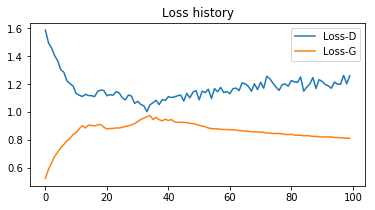

In [14]:
plt.figure(figsize=(6, 3))
plt.plot(histLossD, label='Loss-D')
plt.plot(histLossG, label='Loss-G')
plt.legend()
plt.title("Loss history")
plt.show()

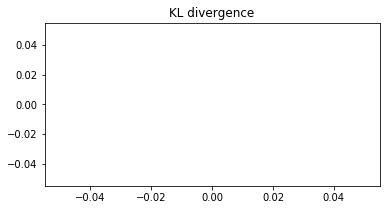

In [15]:
plt.figure(figsize=(6, 3))
plt.plot(histKL)
plt.title("KL divergence")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


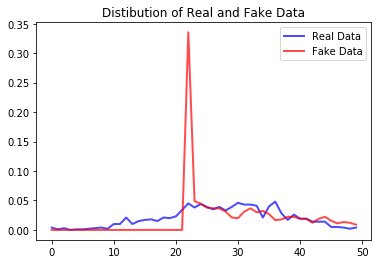

KL divergence = nan


In [16]:
# real data 분포 (p)와 fake data 분포 (q)를 그려본다
fakeData = sess.run(Gz, feed_dict={z : getNoise(m=realData.shape[0], n=nGInput)})
p, q, kld = KL(realData, fakeData)
plt.plot(p, color='blue', linewidth=2.0, alpha=0.7, label='Real Data')
plt.plot(q, color='red', linewidth=2.0, alpha=0.7, label='Fake Data')
plt.legend()
plt.title("Distibution of Real and Fake Data")
plt.show()
print("KL divergence = %.4f" % kld)

In [17]:
# Fake Data를 Discriminator에 넣었을 때 출력값을 확인해 본다.
outputD = sess.run(Dx, feed_dict={x : fakeData})
print(outputD.T)
sess.close() #궁극적으로 구하고자 하는 것, x와 닮았다리

[[0.44316113 0.444411   0.44289878 0.4422574  0.44367155 0.44213262
  0.44400162 0.44275832 0.44391638 0.4432077  0.44386998 0.44276267
  0.44275662 0.444411   0.44329163 0.44258055 0.444411   0.4407578
  0.44428217 0.44338253 0.4434532  0.44166926 0.44419652 0.444411
  0.4414437  0.44251466 0.44336152 0.444411   0.44336715 0.44359058
  0.444411   0.44422886 0.44336778 0.44347692 0.44416296 0.444411
  0.44243807 0.44423297 0.44370183 0.44125238 0.44352832 0.44371346
  0.44355428 0.444411   0.444411   0.44348183 0.4430995  0.44292706
  0.444411   0.44369873 0.4442737  0.44268695 0.444411   0.4434553
  0.44358963 0.444411   0.444411   0.44157815 0.4440689  0.444411
  0.444411   0.44251335 0.4441049  0.44003665 0.44340938 0.44259056
  0.444411   0.444411   0.4436699  0.444411   0.444411   0.44138926
  0.4422375  0.44196695 0.44431338 0.44156823 0.444411   0.44139025
  0.444411   0.44425648 0.44426057 0.4439558  0.44243753 0.444411
  0.444411   0.44190222 0.441594   0.444411   0.4424308  0